In [1]:
NUM_GPU = 1
GPU_NUM = 0

import torch
import os
import sys
from re import I
os.environ["CUDA_VISIBLE_DEVICES"]=f"{NUM_GPU}"
#%env CUDA_VISIBLE_DEVICES=3
#torch.cuda.set_device(NUM_GPU)
device = f'cuda:{GPU_NUM}'
sys.path.append('../')
from vq_gan_3d.model.vqgan import VQGAN
from dataset import MRNetDataset, BRATSDataset, ADNIDataset, DUKEDataset
import matplotlib.pyplot as plt
import SimpleITK as sitk
from ddpm import Unet3D, GaussianDiffusion, Trainer
import pytorch_ssim
from train.get_dataset import get_dataset
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import SimpleITK as sitk



/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
USE_DATASET='DEFAULT'

if USE_DATASET=='LIDC':
	DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/LIDC/model-78.pt'
	VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/LIDC/lightning_logs/version_0/checkpoints/epoch\=100-step\=102000-train/recon_loss\=0.33.ckpt'

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
				"dataset=lidc",
				f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
				"model.diffusion_img_size=16",
				"model.diffusion_depth_size=16",
				"model.diffusion_num_channels=8",
				"model.dim_mults=[1,2,4,8]",
				"model.batch_size=40 ",
				"model.gpus=0 ",
				])

elif USE_DATASET=='ADNI':
	DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/ADNI/roi/model-34.pt'
	VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/ADNI/roi/lightning_logs/version_1/checkpoints/epoch\=99-step\=99000-train/recon_loss\=0.05.ckpt'

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
			 	"dataset=adni",
			 	f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
			 	"model.diffusion_img_size=32",
			 	"model.diffusion_depth_size=32",
			 	"model.diffusion_num_channels=8",
			 	"model.dim_mults=[1,2,4,8]",
			 	"model.batch_size=40 ",
			 	"model.gpus=0 ",
				])

elif USE_DATASET=='DUKE':
	DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/DUKE/model-83.pt'
	VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/DUKE/lightning_logs/version_0/checkpoints/epoch\=58-step\=108000-train/recon_loss\=0.17.ckpt'

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
			 	"dataset=duke",
			 	f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
			 	"model.diffusion_img_size=32",
			 	"model.diffusion_depth_size=4",
			 	"model.diffusion_num_channels=8",
			 	"model.dim_mults=[1,2,4,8]",
			 	"model.batch_size=40 ",
			 	"model.gpus=0 ",
				])

elif USE_DATASET=='MRNet':
	DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/MRNet/model-77.pt'
	VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/MRNet/lightning_logs/version_0/checkpoints/epoch\=126-step\=114000-train/recon_loss\=0.47.ckpt'

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
			 	"dataset=mrnet",
			 	f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
			 	"model.diffusion_img_size=32",
			 	"model.diffusion_depth_size=4",
			 	"model.diffusion_num_channels=8",
			 	"model.dim_mults=[1,2,4,8]",
			 	"model.batch_size=40 ",
			 	"model.gpus=0 ",
				])

elif USE_DATASET=='DEFAULT':
	DDPM_CHECKPOINT = '/home/ge.polymtl.ca/p120530/Training/medif/checkpoints/model-90.pt'
	VQGAN_CHECKPOINT = "/home/ge.polymtl.ca/p120530/Training/medif/checkpoints/0905_e620_rc_0.09.ckpt"

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
				"dataset=default",
				"dataset.root_dir=/home/ge.polymtl.ca/p120530/Training/medif/preprocessed_3D_images",
				f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
				"model.diffusion_img_size=128",
				"model.diffusion_depth_size=8",
				"model.diffusion_num_channels=8",
				"model.dim_mults=[1,2,4,8]",
				"model.batch_size=40 ",
				"model.gpus=0 ",
				])


/tmp/ipykernel_1225310/1776124418.py:24: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../config/"):


In [4]:
train_dataset, _, _ = get_dataset(cfg)

Found 208 files in /home/ge.polymtl.ca/p120530/Training/medif/preprocessed_3D_images
Found 208 files in /home/ge.polymtl.ca/p120530/Training/medif/preprocessed_3D_images


## Evaluate VQ-GAN

In [5]:
vqgan_ckpt = VQGAN_CHECKPOINT.replace("\\", "")
vqgan = VQGAN.load_from_checkpoint(vqgan_ckpt)
# The number of slices in the decoding step is actually a vqgan attribute
vqgan.decoding_diviser = 3
vqgan = vqgan.to(device)
vqgan.eval();

/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from /home/ge.polymtl.ca/p120530/Training/medif/vq_gan_3d/model/cache/vgg.pth


In [6]:
sample = train_dataset[2]
input_ = torch.tensor(sample['data'][None]).to(device)
with torch.no_grad():
	output_ = vqgan(input_)

sitk.WriteImage(sitk.GetImageFromArray(output_[1][0][0].cpu()), '../debug/output.nii')
sitk.WriteImage(sitk.GetImageFromArray(input_[0][0].cpu()), '../debug/input.nii')

/tmp/ipykernel_1225310/2583597794.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(sample['data'][None]).to(device)
** ERROR (nifti_image_write_hdr_img2): cannot open output file '../debug/output.nii'
** ERROR (nifti_image_write_hdr_img2): cannot open output file '../debug/input.nii'


## Evaluate DDPM

In [7]:
model = Unet3D(
    dim=cfg.model.diffusion_img_size,
    dim_mults=cfg.model.dim_mults,
    channels=cfg.model.diffusion_num_channels,
).cuda()

diffusion = GaussianDiffusion(
    model,
    vqgan_ckpt=cfg.model.vqgan_ckpt,
    image_size=cfg.model.diffusion_img_size,
    num_frames=cfg.model.diffusion_depth_size,
    channels=cfg.model.diffusion_num_channels,
    timesteps=cfg.model.timesteps,
    # sampling_timesteps=cfg.model.sampling_timesteps,
    loss_type=cfg.model.loss_type,
    # objective=cfg.objective
).cuda()


trainer = Trainer(
    diffusion,
    cfg=cfg,
    dataset=train_dataset,
    train_batch_size=cfg.model.batch_size,
    save_and_sample_every=cfg.model.save_and_sample_every,
    train_lr=cfg.model.train_lr,
    train_num_steps=cfg.model.train_num_steps,
    gradient_accumulate_every=cfg.model.gradient_accumulate_every,
    ema_decay=cfg.model.ema_decay,
    amp=cfg.model.amp,
    num_sample_rows=cfg.model.num_sample_rows,
    results_folder=cfg.model.results_folder,
    num_workers=cfg.model.num_workers,
    # logger=cfg.model.logger
)



loaded pretrained LPIPS loss from /home/ge.polymtl.ca/p120530/Training/medif/vq_gan_3d/model/cache/vgg.pth
found 208 videos as gif files at None


In [8]:
trainer.load(DDPM_CHECKPOINT, map_location=f'cuda:{GPU_NUM}')

In [9]:
# run diffusion from full complete noise
sample = trainer.ema_model.sample(input_image = input_, denoising = 0.2, batch_size=1)

sampling loop time step:   0%|          | 1/300 [00:00<00:50,  5.87it/s]

59
58


sampling loop time step:   1%|          | 3/300 [00:00<00:52,  5.61it/s]

57
56


sampling loop time step:   2%|▏         | 5/300 [00:00<00:52,  5.57it/s]

55
54


sampling loop time step:   2%|▏         | 7/300 [00:01<00:52,  5.56it/s]

53
52


sampling loop time step:   3%|▎         | 9/300 [00:01<00:52,  5.55it/s]

51
50


sampling loop time step:   4%|▎         | 11/300 [00:01<00:52,  5.54it/s]

49
48


sampling loop time step:   4%|▍         | 13/300 [00:02<00:51,  5.54it/s]

47
46


sampling loop time step:   5%|▌         | 15/300 [00:02<00:51,  5.55it/s]

45
44


sampling loop time step:   6%|▌         | 17/300 [00:03<00:50,  5.56it/s]

43
42


sampling loop time step:   6%|▋         | 19/300 [00:03<00:50,  5.56it/s]

41
40


sampling loop time step:   7%|▋         | 21/300 [00:03<00:50,  5.56it/s]

39
38


sampling loop time step:   8%|▊         | 23/300 [00:04<00:49,  5.56it/s]

37
36


sampling loop time step:   8%|▊         | 25/300 [00:04<00:49,  5.56it/s]

35
34


sampling loop time step:   9%|▉         | 27/300 [00:04<00:49,  5.57it/s]

33
32


sampling loop time step:  10%|▉         | 29/300 [00:05<00:48,  5.57it/s]

31
30


sampling loop time step:  10%|█         | 31/300 [00:05<00:48,  5.57it/s]

29
28


sampling loop time step:  11%|█         | 33/300 [00:05<00:47,  5.56it/s]

27
26


sampling loop time step:  12%|█▏        | 35/300 [00:06<00:47,  5.56it/s]

25
24


sampling loop time step:  12%|█▏        | 37/300 [00:06<00:47,  5.56it/s]

23
22


sampling loop time step:  13%|█▎        | 39/300 [00:07<00:46,  5.56it/s]

21
20


sampling loop time step:  14%|█▎        | 41/300 [00:07<00:46,  5.56it/s]

19
18


sampling loop time step:  14%|█▍        | 43/300 [00:07<00:46,  5.56it/s]

17
16


sampling loop time step:  15%|█▌        | 45/300 [00:08<00:45,  5.56it/s]

15
14


sampling loop time step:  16%|█▌        | 47/300 [00:08<00:45,  5.56it/s]

13
12


sampling loop time step:  16%|█▋        | 49/300 [00:08<00:45,  5.56it/s]

11
10


sampling loop time step:  17%|█▋        | 51/300 [00:09<00:44,  5.56it/s]

9
8


sampling loop time step:  18%|█▊        | 53/300 [00:09<00:44,  5.56it/s]

7
6


sampling loop time step:  18%|█▊        | 55/300 [00:09<00:44,  5.56it/s]

5
4


sampling loop time step:  19%|█▉        | 57/300 [00:10<00:43,  5.56it/s]

3
2


sampling loop time step:  20%|█▉        | 59/300 [00:10<00:43,  5.56it/s]

1
0


sampling loop time step:  20%|██        | 60/300 [00:10<00:43,  5.56it/s]


In [10]:
sample.shape

torch.Size([1, 1, 16, 256, 256])

In [14]:
sample.shape
sample = (sample + 1.0) * 127.5
sitk.WriteImage(sitk.GetImageFromArray(sample[0][0].cpu()), '/home/ge.polymtl.ca/p120530/Training/medif/results_ddpm/sample.nii')

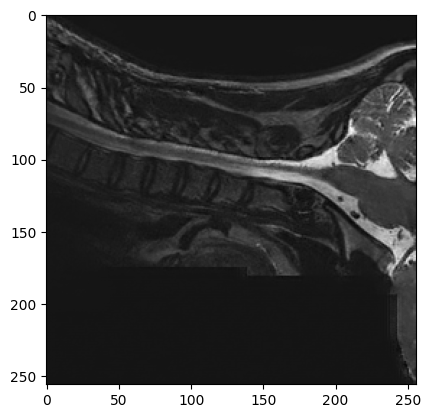

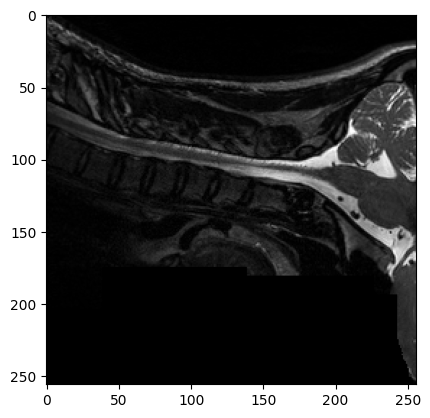

In [15]:
import matplotlib.pyplot as plt
plt.imshow(sample[0][0][8].cpu().numpy(), cmap='gray')
plt.show()

#plot input
plt.imshow(input_[0][0][8].cpu().numpy(), cmap='gray')
plt.show()

In [13]:
sum_ssim = 0
for k in range(20):
    for i,dat in enumerate(train_loader):
        dat = dat['data']
        if len(dat)!=2:
            print("Length: ", len(dat))
            break
        img1 = dat[0]
        img2 = dat[1]

        msssim = pytorch_ssim.msssim_3d(img1,img2)
        sum_ssim = sum_ssim+msssim
    print(sum_ssim/((k+1)*(i+1)))

NameError: name 'train_loader' is not defined

In [ ]:
sum_ssim = 0
for i in range(1000):
    trainer.ema_model.eval()
    with torch.no_grad():
        sample = trainer.ema_model.sample(batch_size=2)
    img1 = sample[0].cpu()
    img2 = sample[1].cpu()

    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    print(sum_ssim/(i+1.0))
print(sum_ssim/1000)

sampling loop time step:  99%|█████████▉| 297/300 [00:18<00:00, 15.97it/s]


KeyboardInterrupt: 

In [ ]:
import nibabel as nib
import numpy as np
import torchio as tio

In [ ]:
img = nib.load('/data/ADNI/ADNI/002_S_0295/FreeSurfer_Cross-Sectional_Processing_brainmask/2006-04-18_08_20_30.0/S13408/ADNI_002_S_0295_VOLUME_FreeSurfer_Cross-Sectional_Processing_Br_20100310173858891.brainmask.nii')

In [ ]:
image = np.asarray(img.get_data())[:, :, :, 0]

/tmp/ipykernel_1738751/2526208013.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  image = np.asarray(img.get_data())[:, :, :, 0]


In [ ]:
# Mask of non-black pixels (assuming image has a single channel).
mask = image > 0

# Coordinates of non-black pixels.
coords = np.argwhere(mask)

# Bounding box of non-black pixels.
x0, y0, z0 = coords.min(axis=0)
x1, y1, z1 = coords.max(axis=0) + 1   # slices are exclusive at the top

# Get the contents of the bounding box.
cropped = image[x0:x1, y0:y1, z0:z1]

In [ ]:
tio.CropOrPad(np.max(cropped.shape))(cropped[None]).shape

(1, 171, 171, 171)

In [ ]:
cropped[None].shape

(1, 138, 171, 148)

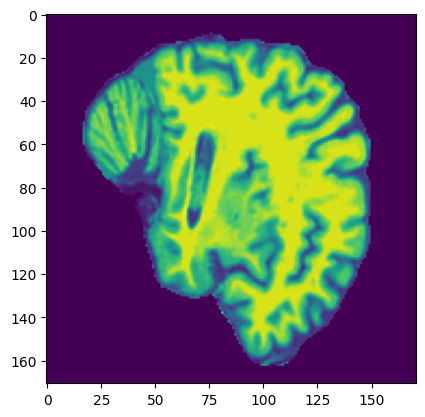

In [ ]:
plt.imshow(tio.CropOrPad(np.max(cropped.shape))(cropped[None])[0][120])

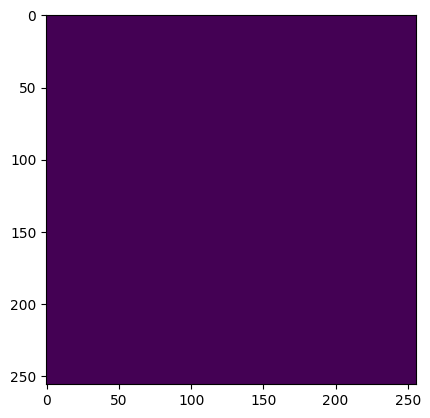

In [ ]:
plt.imshow(image[198])

In [ ]:
image.shape

(256, 256, 256)

In [ ]:
img.shape

(256, 256, 256, 1)

In [ ]:
np.swapaxes(img.get_data(), 0, -1).shape

/tmp/ipykernel_1738751/1229806268.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  np.swapaxes(img.get_data(), 0, -1).shape


(1, 256, 256, 256)